# OULAD Student Performance Prediction

This notebook presents the full pipeline: data loading, cleaning, feature engineering, detailed EDA, modeling, feature selection, and evaluation. It is written to support report writing and reproducibility.

**Default mode**
- Early warning to avoid assessment leakage
- Switch to end-of-course in the modeling cell if needed


## 1. Setup and Configuration

We import required libraries, set plotting and display options, and fix random seeds for reproducibility.


In [1]:
# Core
import os
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Feature selection
from sklearn.feature_selection import RFE

# Bonus models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

pd.set_option('display.max_columns', 200)
np.random.seed(42)



/home/thanm/miniconda3/lib/python3.13/site-packages/joblib/_multiprocessing_helpers.py:44: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn("%s.  joblib will operate in serial mode" % (e,))


In [2]:
# CHANGE THIS to your local folder containing the 7 OULAD CSV files
DEFAULT_DATA_DIR = os.path.join('.', 'data', 'oulad')

required_files = [
    'assessments.csv','courses.csv','studentAssessment.csv','studentInfo.csv',
    'studentRegistration.csv','studentVle.csv','vle.csv'
]

# Resolve DATA_DIR from common locations
candidate_dirs = [DEFAULT_DATA_DIR, '.']
resolved = None
for d in candidate_dirs:
    if all(os.path.exists(os.path.join(d, f)) for f in required_files):
        resolved = d
        break

if resolved is None:
    missing = [f for f in required_files if not os.path.exists(os.path.join(DEFAULT_DATA_DIR, f))]
    print('Missing files in DEFAULT_DATA_DIR:', missing)
    print('DEFAULT_DATA_DIR currently set to:', os.path.abspath(DEFAULT_DATA_DIR))
    print('Also checked:', os.path.abspath('.'))
else:
    DATA_DIR = resolved
    print('Using DATA_DIR:', os.path.abspath(DATA_DIR))


Using DATA_DIR: /mnt/d/Project/DBM_FINAL


## 2. Data Loading and Overview

We load the seven OULAD CSV files and confirm shapes to ensure the dataset is complete.


In [3]:
def read_csv(name, usecols=None, dtype=None):
    path = os.path.join(DATA_DIR, name)
    return pd.read_csv(path, usecols=usecols, dtype=dtype, low_memory=False)
def preview_df(name, df, n=5):
    print(f"\nPreview: {name}")
    print('shape:', df.shape)
    print(df.head(n))

# Read small/medium tables fully
assessments = read_csv('assessments.csv')
courses = read_csv('courses.csv')
student_info = read_csv('studentInfo.csv')
student_reg = read_csv('studentRegistration.csv')
student_assess = read_csv('studentAssessment.csv')
vle = read_csv('vle.csv')

# Read the large clickstream table with only needed columns + smaller dtypes
student_vle = read_csv(
    'studentVle.csv',
    usecols=['code_module','code_presentation','id_student','id_site','date','sum_click'],
    dtype={
        'code_module':'category','code_presentation':'category',
        'id_student':'int32','id_site':'int32',
        'date':'int16','sum_click':'int32'
    }
)

# Quick overview (rows, cols)
overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
overview




,table,rows,cols
0,assessments,206,6
1,courses,22,3
2,studentInfo,32593,12
3,studentRegistration,32593,5
4,studentAssessment,173912,5
5,vle,6364,6
6,studentVle,10655280,6


## 3. Data Cleaning and Justification

**Cleaning steps**
- Remove known invalid assessment IDs
- Convert non-numeric score values and drop missing scores
- Deduplicate VLE click records
- Preserve missing values for imputation

**Why it matters**
- Reduces noise
- Prevents incorrect aggregates
- Keeps the modeling pipeline stable


In [4]:
# --- 3.1 assessments: drop known invalid IDs (common in OULAD copies)
# If IDs are missing in your version, this line is harmless.
invalid_ids = {40087, 40088}
assessments = assessments[~assessments['id_assessment'].isin(invalid_ids)].copy()

# Ensure numeric types where needed
assessments['weight'] = pd.to_numeric(assessments['weight'], errors='coerce')
assessments['date'] = pd.to_numeric(assessments['date'], errors='coerce')

# --- 3.2 studentAssessment: clean score/date
student_assess['score'] = student_assess['score'].replace(['?', '', ' '], np.nan)
student_assess['score'] = pd.to_numeric(student_assess['score'], errors='coerce')
student_assess['date_submitted'] = pd.to_numeric(student_assess['date_submitted'], errors='coerce')
student_assess['is_banked'] = pd.to_numeric(student_assess['is_banked'], errors='coerce').fillna(0).astype(int)

before = len(student_assess)
student_assess = student_assess.dropna(subset=['score']).copy()
print('Dropped rows with missing/non-numeric score:', before - len(student_assess))

# --- 3.3 studentInfo: clean imd_band and normalize age label
student_info['imd_band'] = student_info['imd_band'].replace('?', np.nan)
student_info['age_band'] = student_info['age_band'].replace({'55<=': '>=55'})

# --- 3.4 studentVle: drop duplicates to avoid inflated click counts
before = len(student_vle)
student_vle = student_vle.drop_duplicates().copy()
print('Dropped duplicate rows in studentVle:', before - len(student_vle))

# Sanity
print('studentVle rows after dedup:', len(student_vle))


Dropped rows with missing/non-numeric score: 173


Dropped duplicate rows in studentVle: 787170
studentVle rows after dedup: 9868110


## 4. Feature Engineering and Transformation

**Core features**
- Target creation as Pass or Fail
- VLE engagement aggregates and ratios
- Activity-type click profiles and diversity measures
- Assessment summaries for analysis
- Registration signals

**Transformations**
- Log transforms for skewed counts
- Outlier capping for stability


In [5]:
# --- 4.1 Create target (binary) from final_result
student_info['final_result_upd'] = student_info['final_result'].replace({
    'Distinction': 'Pass',
    'Withdrawn': 'Fail'
})
student_info = student_info[student_info['final_result_upd'].isin(['Pass','Fail'])].copy()
student_info['final_result_upd_numeric'] = (student_info['final_result_upd'] == 'Pass').astype(int)

# --- 4.2 VLE features (aggregate to student-module-presentation grain)
# total clicks + active days
vle_agg = (
    student_vle
    .groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
    .agg(
        total_sum_click=('sum_click','sum'),
        active_days=('date','nunique'),
        distinct_sites=('id_site','nunique')
    )
)

# early engagement (<= 14 days)
early = student_vle[student_vle['date'] <= 14]
early_agg = (
    early.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
         .agg(early_sum_click=('sum_click','sum'), early_active_days=('date','nunique'))
)

vle_features = vle_agg.merge(early_agg, on=['id_student','code_module','code_presentation'], how='left')
vle_features[['early_sum_click','early_active_days']] = vle_features[['early_sum_click','early_active_days']].fillna(0)

vle_features['early_click_ratio'] = vle_features['early_sum_click'] / vle_features['total_sum_click'].replace(0, np.nan)
vle_features['early_click_ratio'] = vle_features['early_click_ratio'].fillna(0)

# per-day intensity
vle_features['clicks_per_active_day'] = vle_features['total_sum_click'] / vle_features['active_days'].replace(0, np.nan)
vle_features['clicks_per_active_day'] = vle_features['clicks_per_active_day'].fillna(0)

vle_features['early_clicks_per_active_day'] = vle_features['early_sum_click'] / vle_features['early_active_days'].replace(0, np.nan)
vle_features['early_clicks_per_active_day'] = vle_features['early_clicks_per_active_day'].fillna(0)

vle_features['early_active_ratio'] = vle_features['early_active_days'] / vle_features['active_days'].replace(0, np.nan)
vle_features['early_active_ratio'] = vle_features['early_active_ratio'].fillna(0)

# activity type aggregates
vle_types = student_vle.merge(vle[['id_site','activity_type']], on='id_site', how='left')

vle_type_agg = (
    vle_types.groupby(['id_student','code_module','code_presentation','activity_type'], observed=True)
             .agg(type_clicks=('sum_click','sum'))
             .reset_index()
)

vle_type_pivot = vle_type_agg.pivot_table(
    index=['id_student','code_module','code_presentation'],
    columns='activity_type',
    values='type_clicks',
    fill_value=0
).reset_index()

# Rename columns for clarity
for col in vle_type_pivot.columns:
    if col not in ['id_student','code_module','code_presentation']:
        vle_type_pivot = vle_type_pivot.rename(columns={col: f'clicks_type_{col}'})

# Merge activity type features into main VLE feature set
vle_features = vle_features.merge(vle_type_pivot, on=['id_student','code_module','code_presentation'], how='left')

# Count of activity types used
type_cols = [c for c in vle_features.columns if c.startswith('clicks_type_')]
vle_features['distinct_activity_types'] = (vle_features[type_cols] > 0).sum(axis=1)
# activity type distribution features
type_cols = [c for c in vle_features.columns if c.startswith('clicks_type_')]
type_sum = vle_features[type_cols].sum(axis=1).replace(0, np.nan)
type_probs = vle_features[type_cols].div(type_sum, axis=0).fillna(0)
vle_features['activity_entropy'] = -(type_probs * np.log(type_probs + 1e-9)).sum(axis=1)
vle_features['top_type_share'] = type_probs.max(axis=1)

# log transforms to reduce skew
vle_features['log1p_total_sum_click'] = np.log1p(vle_features['total_sum_click'])
vle_features['log1p_early_sum_click'] = np.log1p(vle_features['early_sum_click'])

# Transparency: check target transformation
preview_df('student_info (target)', student_info)

# Transparency: VLE aggregates
preview_df('vle_agg', vle_agg)
preview_df('early_agg', early_agg)
preview_df('vle_features', vle_features)




/tmp/ipykernel_71797/2356727492.py:53: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  vle_type_pivot = vle_type_agg.pivot_table(



Preview: student_info (target)
shape: (32593, 14)
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     >=55                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result final_result_upd  \
0              240  

In [6]:
# --- 4.3 Assessment features: weighted score and overall grade
# Join studentAssessment with assessments metadata
sa = student_assess.merge(
    assessments[['id_assessment','code_module','code_presentation','assessment_type','weight','date']],
    on='id_assessment', how='left'
)

# Weighted score rule: if is_banked==1 -> 0 else score * weight
sa['weighted_score'] = np.where(sa['is_banked'] == 1, 0, sa['score'] * (sa['weight'] / 100.0))

# Lateness (optional feature)
sa['lateness_days'] = sa['date_submitted'] - sa['date']

assess_agg = (
    sa.groupby(['id_student','code_module','code_presentation'], as_index=False, observed=True)
      .agg(
          exam_weighted=('weighted_score', lambda x: x[sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          non_exam_weighted=('weighted_score', lambda x: x[~sa.loc[x.index,'assessment_type'].eq('Exam')].sum()),
          mean_score=('score','mean'),
          late_submissions=('lateness_days', lambda s: (s>0).sum())
      )
)

# overall_grade rule: average if both exist, else use the one available
assess_agg['has_exam'] = (assess_agg['exam_weighted'] > 0).astype(int)
assess_agg['has_non_exam'] = (assess_agg['non_exam_weighted'] > 0).astype(int)
assess_agg['overall_grade'] = np.where(
    (assess_agg['has_exam']==1) & (assess_agg['has_non_exam']==1),
    (assess_agg['exam_weighted'] + assess_agg['non_exam_weighted']) / 2.0,
    np.where(assess_agg['has_exam']==1, assess_agg['exam_weighted'], assess_agg['non_exam_weighted'])
)

# Transparency: assessment aggregates
preview_df('assess_agg', assess_agg)




Preview: assess_agg
shape: (25820, 10)
   id_student code_module code_presentation  exam_weighted  non_exam_weighted  \
0        6516         AAA             2014J            0.0              63.50   
1        8462         DDD             2013J            0.0              34.90   
2        8462         DDD             2014J            0.0               0.00   
3       11391         AAA             2013J            0.0              82.40   
4       23629         BBB             2013B            0.0              16.69   

   mean_score  late_submissions  has_exam  has_non_exam  overall_grade  
0   61.800000                 0         0             1          63.50  
1   87.666667                 1         0             1          34.90  
2   86.500000                 0         0             0           0.00  
3   82.000000                 0         0             1          82.40  
4   82.500000                 3         0             1          16.69  


In [7]:
# --- 4.4 Registration features
student_reg['date_registration'] = pd.to_numeric(student_reg['date_registration'], errors='coerce')
student_reg['date_unregistration'] = pd.to_numeric(student_reg['date_unregistration'], errors='coerce')

reg_features = student_reg[['id_student','code_module','code_presentation','date_registration','date_unregistration']].copy()
reg_features['unregistered_flag'] = reg_features['date_unregistration'].notna().astype(int)

# Transparency: registration features
preview_df('reg_features', reg_features)




Preview: reg_features
shape: (32593, 6)
   id_student code_module code_presentation  date_registration  \
0       11391         AAA             2013J             -159.0   
1       28400         AAA             2013J              -53.0   
2       30268         AAA             2013J              -92.0   
3       31604         AAA             2013J              -52.0   
4       32885         AAA             2013J             -176.0   

   date_unregistration  unregistered_flag  
0                  NaN                  0  
1                  NaN                  0  
2                 12.0                  1  
3                  NaN                  0  
4                  NaN                  0  


In [8]:
# --- 4.5 Build final dataset at student-module-presentation grain
final_data = (
    student_info
      .merge(vle_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(assess_agg, on=['id_student','code_module','code_presentation'], how='left')
      .merge(reg_features, on=['id_student','code_module','code_presentation'], how='left')
      .merge(courses, on=['code_module','code_presentation'], how='left')
)

# Derived registration and engagement ratios
if 'date_registration' in final_data.columns:
    final_data['registered_early_flag'] = (final_data['date_registration'] < 0).astype(int)
    final_data['registration_lead_days'] = (-final_data['date_registration']).clip(lower=0)

if 'date_unregistration' in final_data.columns:
    final_data['unregistered_flag'] = final_data['date_unregistration'].notna().astype(int)

if 'module_presentation_length' in final_data.columns:
    final_data['active_days_ratio'] = final_data['active_days'] / final_data['module_presentation_length'].replace(0, np.nan)
    final_data['active_days_ratio'] = final_data['active_days_ratio'].fillna(0)

# Fill missing engineered numeric values
# Drop rows with missing values in this feature list
feature_cols = [
    'total_sum_click','active_days','early_sum_click','early_active_days','early_click_ratio',
    'clicks_per_active_day','early_clicks_per_active_day','early_active_ratio',
    'distinct_sites','distinct_activity_types','activity_entropy','top_type_share',
    'log1p_total_sum_click','log1p_early_sum_click','exam_weighted','non_exam_weighted',
    'mean_score','late_submissions','overall_grade','unregistered_flag',
    'registered_early_flag','registration_lead_days','active_days_ratio'
]

row_na_cols = [c for c in feature_cols if c in final_data.columns]
if row_na_cols:
    before = len(final_data)
    final_data = final_data.dropna(subset=row_na_cols)
    print('Dropped rows with NA in feature list:', before - len(final_data))

print('Final dataset shape:', final_data.shape)
final_data[['final_result_upd','final_result_upd_numeric']].value_counts().head()

# Transparency: final dataset preview
preview_df('final_data', final_data)





Dropped rows with NA in feature list: 6827
Final dataset shape: (25766, 62)

Preview: final_data
shape: (25766, 62)
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   
5         AAA             2013J       38053      M                 Wales   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     >=55                     0   
1       HE Qualification   20-30%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   
5  A Level or Equivalent   80-90%    35-55                     0   

   studied_credits

**Leakage feature removal**

We remove assessment-derived features in early-warning analysis to prevent leakage. These features will not appear in EDA or modeling.


In [9]:
# --- 4.5b Drop leakage features for early-warning analysis
LEAKAGE_FEATURES = ['overall_grade','exam_weighted','non_exam_weighted','mean_score','late_submissions']
leak_drop = [c for c in LEAKAGE_FEATURES if c in final_data.columns]
if leak_drop:
    final_data = final_data.drop(columns=leak_drop)
    print('Dropped leakage features:', leak_drop)


Dropped leakage features: ['overall_grade', 'exam_weighted', 'non_exam_weighted', 'mean_score', 'late_submissions']


**Zero activity investigation**

We quantify zero engagement rows and optionally drop them for a sensitivity check. This can reduce noise without changing raw CSVs.


In [10]:
# --- 4.5a Zero-activity investigation
zero_cols = [c for c in ['total_sum_click','active_days','early_sum_click','early_active_days','distinct_sites'] if c in final_data.columns]
if zero_cols:
    zero_mask = (final_data[zero_cols].sum(axis=1) == 0)
    print('Rows with zero engagement across key columns:', zero_mask.mean().round(4), 'of dataset')
    print('Count:', zero_mask.sum())
else:
    zero_mask = None

# Toggle removal for analysis (does not change raw data)
DROP_ZERO_ACTIVITY = True
if DROP_ZERO_ACTIVITY and zero_mask is not None:
    final_data = final_data.loc[~zero_mask].copy()
    print('After dropping zero-activity rows:', final_data.shape)



Rows with zero engagement across key columns: 0.0 of dataset
Count: 0
After dropping zero-activity rows: (25766, 57)


In [11]:
# --- 4.6 Outlier handling (winsorize at 1st/99th percentile)
outlier_cols = [
    'total_sum_click','early_sum_click','active_days','overall_grade',
    'mean_score','late_submissions','exam_weighted','non_exam_weighted'
]
cap_rows = []
for c in outlier_cols:
    if c in final_data.columns:
        low, high = final_data[c].quantile([0.01, 0.99])
        cap_rows.append({'feature': c, 'p01': low, 'p99': high})
        final_data[c] = final_data[c].clip(lower=low, upper=high)

cap_df = pd.DataFrame(cap_rows)
if len(cap_df):
    cap_df
else:
    print('No outlier columns found to cap.')


## 5. Exploratory Data Analysis

The EDA is organized into compact multi-plot blocks. This keeps the analysis detailed without becoming too long.

Note: assessment-derived leakage features are removed before EDA to avoid leakage in plots.


### 5.1 Overview, Missingness, and Target Balance

This block shows dataset sizes, missing value rates, and class balance.


                 table     rows  cols
0          assessments      204     6
1              courses       22     3
2          studentInfo    32593    14
3  studentRegistration    32593     5
4    studentAssessment   173739     5
5                  vle     6364     6
6           studentVle  9868110     6


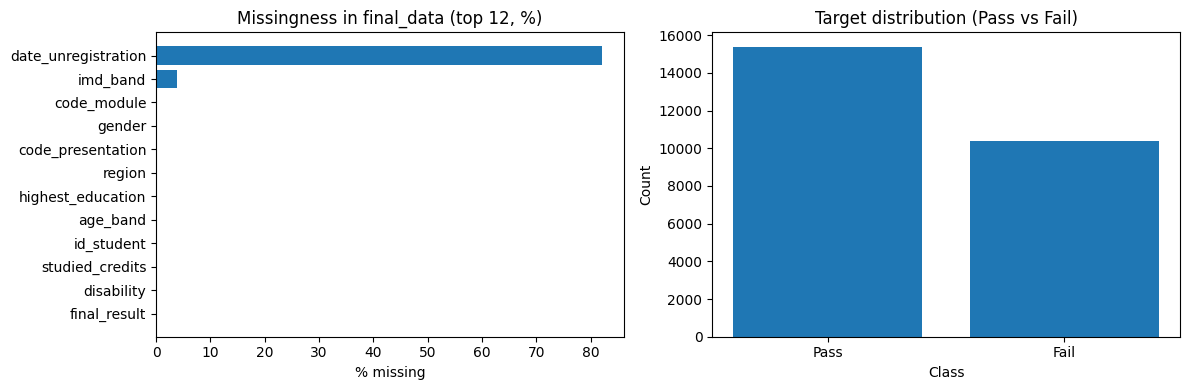

Target counts:
final_result_upd
Pass    15380
Fail    10386
Name: count, dtype: int64
Target %:
final_result_upd
Pass    59.69
Fail    40.31
Name: count, dtype: float64
Imbalance ratio (majority/minority): 1.48x


In [12]:
# --- 5.1 Data overview + missingness + target balance
import math

overview = pd.DataFrame({
    'table': ['assessments','courses','studentInfo','studentRegistration','studentAssessment','vle','studentVle'],
    'rows': [len(assessments),len(courses),len(student_info),len(student_reg),len(student_assess),len(vle),len(student_vle)],
    'cols': [assessments.shape[1],courses.shape[1],student_info.shape[1],student_reg.shape[1],student_assess.shape[1],vle.shape[1],student_vle.shape[1]]
})
print(overview)

miss = (final_data.isna().mean() * 100).sort_values(ascending=False).head(12)
counts = final_data['final_result_upd'].value_counts()
perc = counts / counts.sum() * 100
imbalance = counts.max() / counts.min()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].barh(miss.index.astype(str), miss.values)
axes[0].set_title('Missingness in final_data (top 12, %)')
axes[0].invert_yaxis()
axes[0].set_xlabel('% missing')

axes[1].bar(counts.index, counts.values)
axes[1].set_title('Target distribution (Pass vs Fail)')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')

plt.tight_layout()
plt.show()

print('Target counts:')
print(counts)
print('Target %:')
print(perc.round(2))
print(f'Imbalance ratio (majority/minority): {imbalance:.2f}x')


### 5.2 Distributions and Class Separation

We show histograms and boxplots for key numeric features to understand spread, skew, and class separation.


/tmp/ipykernel_71797/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
/tmp/ipykernel_71797/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
/tmp/ipykernel_71797/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
/tmp/ipykernel_71797/3237998458.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' 

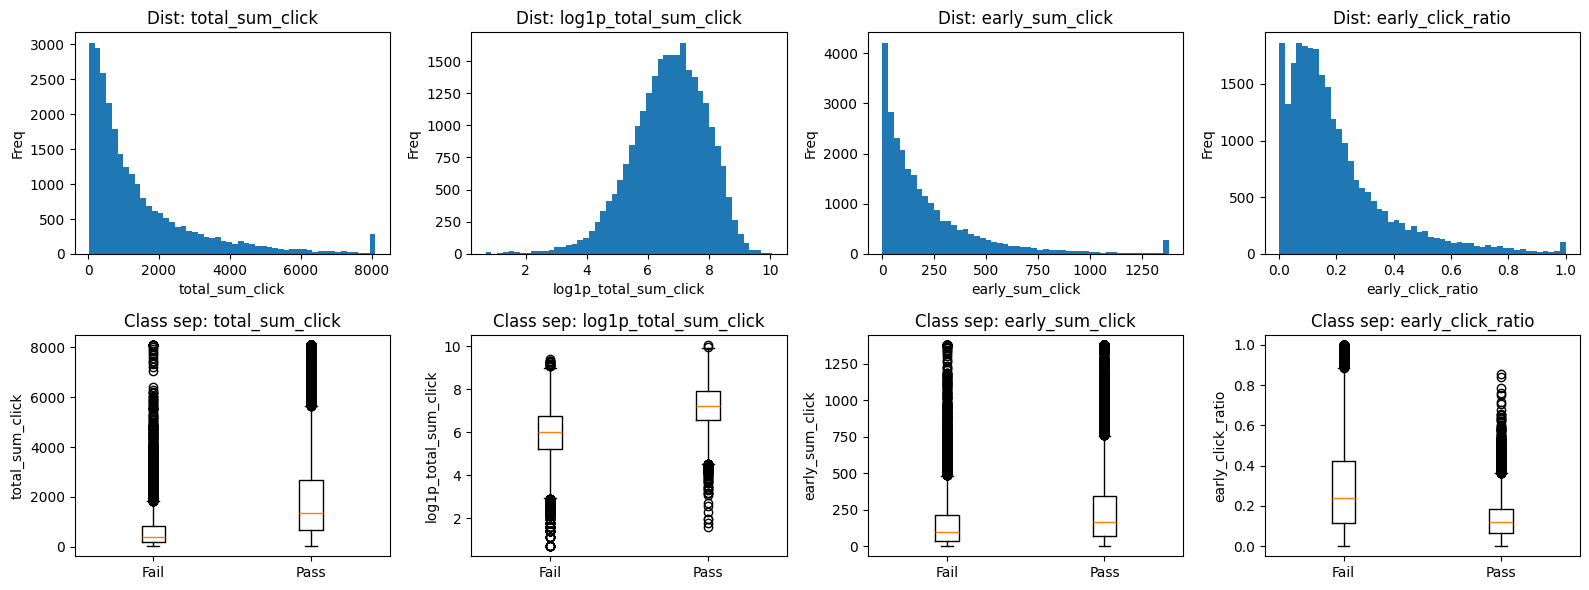

In [13]:
# --- 5.2 Distributions + class separation (single block)
key_num = [
    'total_sum_click','log1p_total_sum_click','early_sum_click','early_click_ratio',
    'active_days','overall_grade','mean_score','late_submissions'
]
cols = [c for c in key_num if c in final_data.columns]

ncols = 4
nrows = 2  # top row: hist, bottom row: boxplot
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 6))

for i, col in enumerate(cols[:ncols]):
    ax = axes[0, i]
    ax.hist(final_data[col].dropna(), bins=50)
    ax.set_title(f'Dist: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Freq')

    ax2 = axes[1, i]
    pass_vals = final_data.loc[final_data['final_result_upd_numeric']==1, col]
    fail_vals = final_data.loc[final_data['final_result_upd_numeric']==0, col]
    ax2.boxplot([fail_vals.dropna(), pass_vals.dropna()], labels=['Fail','Pass'])
    ax2.set_title(f'Class sep: {col}')
    ax2.set_ylabel(col)

# hide unused axes if fewer than 4 features
for j in range(len(cols[:ncols]), ncols):
    axes[0, j].axis('off')
    axes[1, j].axis('off')

plt.tight_layout()
plt.show()


### 5.3 Pass Rates by Demographics

We compare pass rates across key demographic attributes such as gender, age band, education, and IMD band.


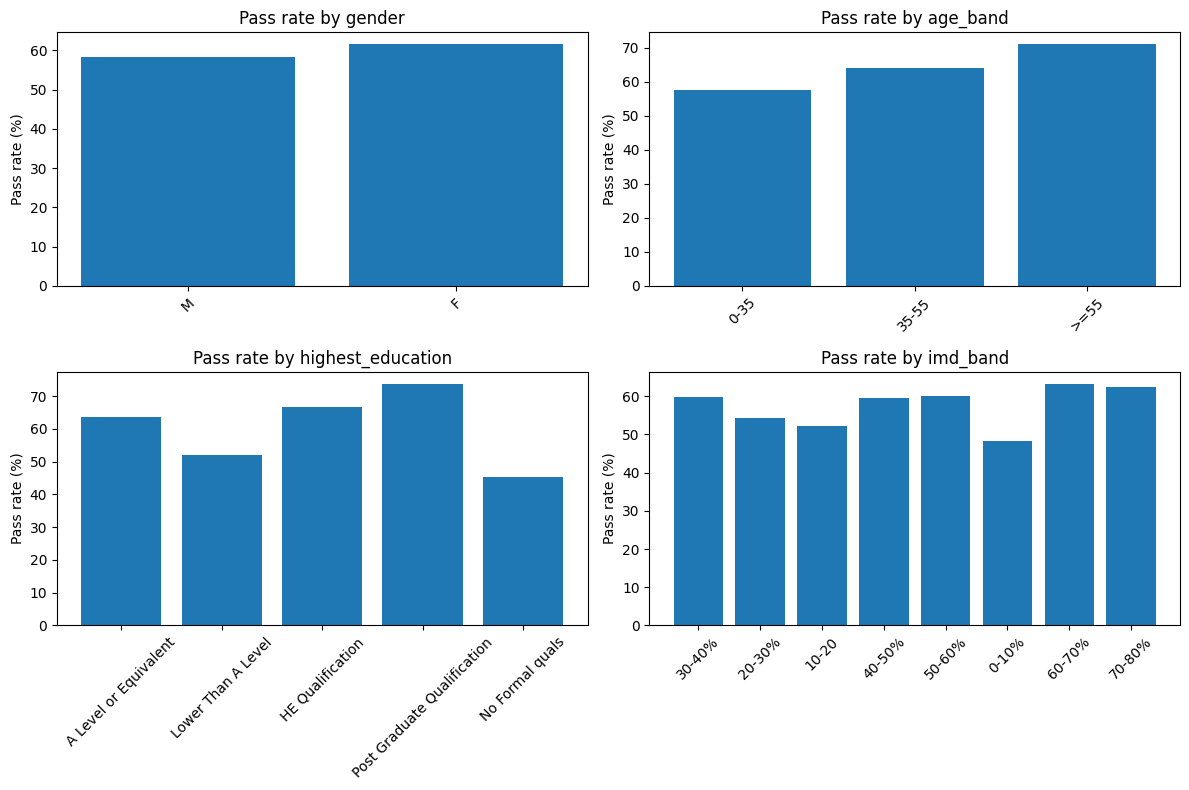

In [14]:
# --- 5.3 Pass rates by demographics (key factors)
cat_cols = ['gender','age_band','highest_education','imd_band']

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    if col not in final_data.columns:
        ax.axis('off')
        continue

    grp = (
        final_data.groupby(col)['final_result_upd_numeric']
        .agg(['mean','count'])
        .sort_values('count', ascending=False)
        .head(8)
    )
    ax.bar(grp.index.astype(str), grp['mean'] * 100)
    ax.set_title(f'Pass rate by {col}')
    ax.set_ylabel('Pass rate (%)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 5.4 Pass Rates by Module

We highlight differences in outcomes across modules to identify course-level patterns.


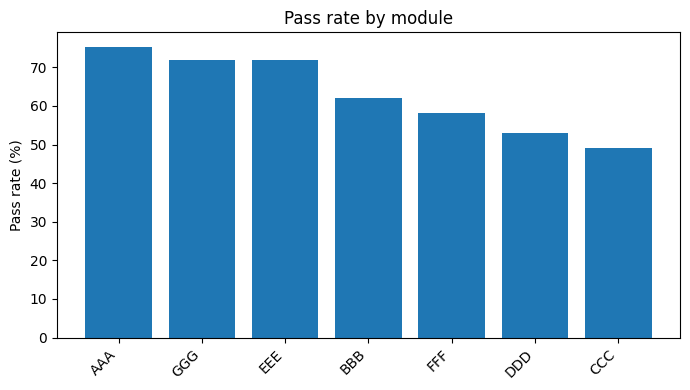

In [15]:
# --- 5.4 Pass rates by module
if 'code_module' in final_data.columns:
    module_rates = (
        final_data.groupby('code_module')['final_result_upd_numeric']
        .agg(['mean','count'])
        .sort_values('mean', ascending=False)
    )

    plt.figure(figsize=(7,4))
    plt.bar(module_rates.index.astype(str), module_rates['mean'] * 100)
    plt.title('Pass rate by module')
    plt.ylabel('Pass rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### 5.5 Correlations with the Target

We inspect the strongest numeric correlations with the target to identify candidate predictors.


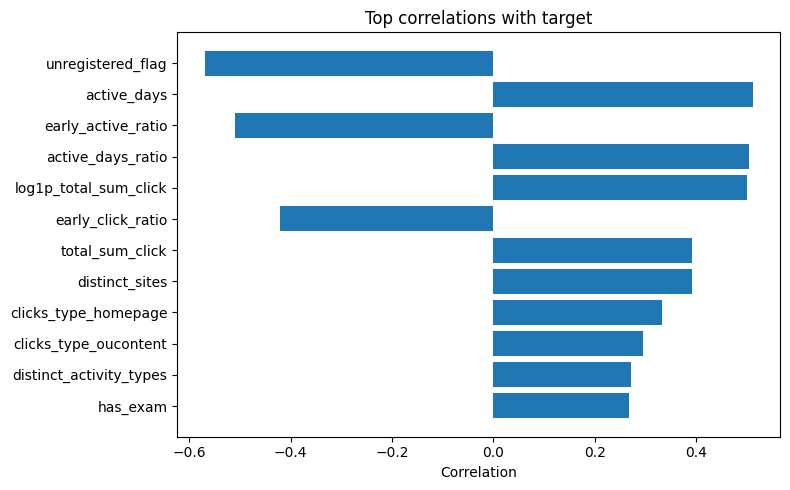

In [16]:
# --- 5.5 Correlations with target (numeric features)
num_cols = final_data.select_dtypes(include=['number']).columns.tolist()
if 'final_result_upd_numeric' in num_cols:
    corrs = (
        final_data[num_cols]
        .corr()['final_result_upd_numeric']
        .drop('final_result_upd_numeric')
        .sort_values(key=lambda s: s.abs(), ascending=False)
    )
    top_corrs = corrs.head(12)

    plt.figure(figsize=(8,5))
    plt.barh(top_corrs.index.astype(str), top_corrs.values)
    plt.title('Top correlations with target')
    plt.xlabel('Correlation')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    top_corrs


## 6. Modeling Baseline

A single pipeline performs imputation, scaling, one-hot encoding, and logistic regression.


### 6.1 Algorithm Notes

- Logistic regression for interpretability
- Decision tree for non-linear patterns
- Random forest and boosting for stronger accuracy


In [17]:
# Define X, y
TARGET = 'final_result_upd_numeric'
DROP_COLS = ['final_result', 'final_result_upd', TARGET]

X = final_data.drop(columns=[c for c in DROP_COLS if c in final_data.columns])
y = final_data[TARGET].astype(int)

# Prediction goal controls potential leakage features
PREDICTION_GOAL = 'early_warning'  # options: 'end_of_course', 'early_warning'
LEAKAGE_FEATURES = [
    'overall_grade','exam_weighted','non_exam_weighted','mean_score','late_submissions'
]

if PREDICTION_GOAL == 'early_warning':
    drop_cols = [c for c in LEAKAGE_FEATURES if c in X.columns]
    X = X.drop(columns=drop_cols)
    print('Early-warning mode: dropping assessment-derived features:', drop_cols)
else:
    print('End-of-course mode: using full feature set (including assessment-derived features).')

# Split (stratified for fair class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Column types
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatibility across sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', ohe)
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

baseline_clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)

baseline_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', baseline_clf)
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}

print('Baseline metrics')
for k, v in baseline_metrics.items():
    print(f'{k}: {v:.4f}')



Early-warning mode: dropping assessment-derived features: []


Baseline metrics
Accuracy: 0.8875
Precision: 0.8842
Recall: 0.9337
F1: 0.9083


In [18]:
# --- 6.2 Threshold tuning for accuracy (no leakage)
from sklearn.metrics import accuracy_score

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))])
pipe.fit(X_tr, y_tr)

val_probs = pipe.predict_proba(X_val)[:, 1]
thresholds = [i/100 for i in range(10, 91, 5)]
accs = []
for t in thresholds:
    preds = (val_probs >= t).astype(int)
    accs.append(accuracy_score(y_val, preds))

best_idx = int(max(range(len(accs)), key=lambda i: accs[i]))
best_t = thresholds[best_idx]
print('Best threshold on validation:', best_t)

# Apply best threshold to test set
probs_test = pipe.predict_proba(X_test)[:, 1]
pred_test = (probs_test >= best_t).astype(int)

threshold_metrics = {
    'Accuracy': accuracy_score(y_test, pred_test),
    'Precision': precision_score(y_test, pred_test),
    'Recall': recall_score(y_test, pred_test),
    'F1': f1_score(y_test, pred_test)
}
print('Threshold-tuned metrics:', threshold_metrics)



Best threshold on validation: 0.35
Threshold-tuned metrics: {'Accuracy': 0.8892122623205277, 'Precision': 0.8598103993105429, 'Recall': 0.9730169050715215, 'F1': 0.9129174927558334}


## 7. Feature Selection and Leakage Analysis

We use RFECV for feature selection and explicitly avoid assessment-derived leakage in early-warning mode.


### 7.0 Leakage Analysis

Assessment features directly reflect grading and are excluded in early-warning mode.


In [19]:
# --- 7.0 Assessment timing + leakage check
assess_stats = (
    assessments.groupby('assessment_type')
    .agg(
        count=('id_assessment','count'),
        median_weight=('weight','median'),
        median_date=('date','median')
    )
    .sort_values('count', ascending=False)
)
assess_stats

# Exam timing relative to course length
assess_len = assessments.merge(courses, on=['code_module','code_presentation'], how='left')
exam = assess_len[assess_len['assessment_type'] == 'Exam'].copy()
if len(exam):
    exam['date_pct'] = exam['date'] / exam['module_presentation_length']
    print('Median exam date as % of course length:', round(exam['date_pct'].median()*100, 1), '%')

# Strength of correlation for assessment-derived features
for col in ['overall_grade','exam_weighted','non_exam_weighted','mean_score','late_submissions']:
    if col in final_data.columns:
        corr = final_data[[col,'final_result_upd_numeric']].corr().iloc[0,1]
        print(f'Correlation with target: {col} -> {corr:.3f}')


Median exam date as % of course length: 92.1 %


### 7.1 RFECV Selection Curve

Cross-validation selects the number of features that yields the best F1 score.


Optimal number of features: 92
Selected features:
 - id_student
 - num_of_prev_attempts
 - studied_credits
 - total_sum_click
 - active_days
 - distinct_sites
 - early_sum_click
 - early_active_days
 - early_click_ratio
 - clicks_per_active_day
 - early_clicks_per_active_day
 - early_active_ratio
 - clicks_type_dataplus
 - clicks_type_dualpane
 - clicks_type_externalquiz
 - clicks_type_folder
 - clicks_type_forumng
 - clicks_type_glossary
 - clicks_type_homepage
 - clicks_type_htmlactivity
 - clicks_type_oucollaborate
 - clicks_type_oucontent
 - clicks_type_ouelluminate
 - clicks_type_ouwiki
 - clicks_type_page
 - clicks_type_questionnaire
 - clicks_type_quiz
 - clicks_type_repeatactivity
 - clicks_type_resource
 - clicks_type_sharedsubpage
 - clicks_type_subpage
 - clicks_type_url
 - distinct_activity_types
 - activity_entropy
 - top_type_share
 - log1p_total_sum_click
 - log1p_early_sum_click
 - has_exam
 - has_non_exam
 - date_registration
 - date_unregistration
 - unregistered_flag

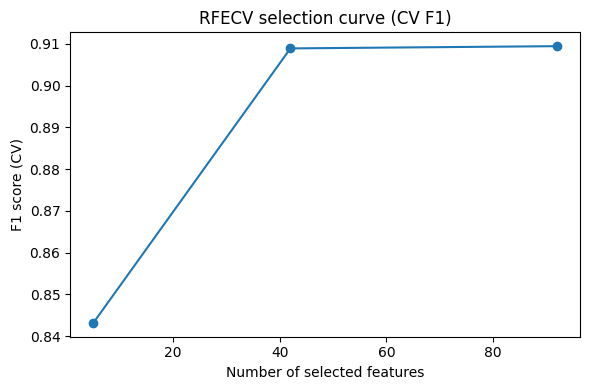


RFECV-selected model metrics
Accuracy: 0.8875
Precision: 0.8842
Recall: 0.9337
F1: 0.9083


In [20]:
# --- 7.1 RFECV selection curve (cross-validated)
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

preprocess_fs = clone(preprocess)
X_train_t = preprocess_fs.fit_transform(X_train)
X_test_t = preprocess_fs.transform(X_test)

# Feature names after preprocessing
ohe = preprocess_fs.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
feature_names = np.array(num_cols + list(cat_names))

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    step=50,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    min_features_to_select=5
)

rfecv.fit(X_train_t, y_train)

selected_mask = rfecv.support_
selected_features = feature_names[selected_mask]

print('Optimal number of features:', rfecv.n_features_)
print('Selected features:')
for f in selected_features:
    print(' -', f)

# Plot selection curve
if hasattr(rfecv, 'cv_results_'):
    n_features = rfecv.cv_results_['n_features']
    scores = rfecv.cv_results_['mean_test_score']
else:
    n_features = range(1, len(rfecv.grid_scores_) + 1)
    scores = rfecv.grid_scores_

plt.figure(figsize=(6,4))
plt.plot(n_features, scores, marker='o')
plt.title('RFECV selection curve (CV F1)')
plt.xlabel('Number of selected features')
plt.ylabel('F1 score (CV)')
plt.tight_layout()
plt.show()

# Train LR on selected features
clf_fs = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
clf_fs.fit(X_train_t[:, selected_mask], y_train)

y_pred_fs = clf_fs.predict(X_test_t[:, selected_mask])

rfecv_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_fs),
    'Precision': precision_score(y_test, y_pred_fs),
    'Recall': recall_score(y_test, y_pred_fs),
    'F1': f1_score(y_test, y_pred_fs)
}

print('')
print('RFECV-selected model metrics')
for k, v in rfecv_metrics.items():
    print(f'{k}: {v:.4f}')



In [21]:
# --- 7.3 Top features (importance proxy via |coef| for LR)
coefs = clf_fs.coef_.ravel()
coef_df = pd.DataFrame({'feature': selected_features, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).drop(columns='abs_coef')

coef_df


,feature,coef
48,code_module_CCC,-3.699360
49,code_module_DDD,-3.529362
41,unregistered_flag,-2.670618
52,code_module_GGG,2.343383
47,code_module_BBB,2.256838
...,...,...
20,clicks_type_oucollaborate,0.019268
28,clicks_type_resource,-0.013653
2,studied_credits,-0.010661
70,region_West Midlands Region,0.003597


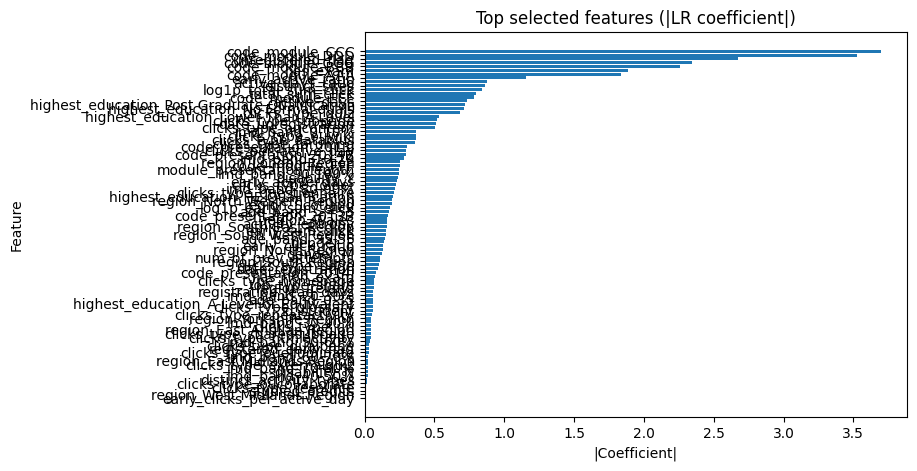

In [22]:
# Plot top features by |coef|
plot_df = coef_df.copy()
plot_df['abs_coef'] = plot_df['coef'].abs()
plot_df = plot_df.sort_values('abs_coef', ascending=True)

plt.figure(figsize=(7, 5))
plt.barh(plot_df['feature'], plot_df['abs_coef'])
plt.title('Top selected features (|LR coefficient|)')
plt.xlabel('|Coefficient|')
plt.ylabel('Feature')
plt.show()


In [23]:
# --- 7.5 Direction of top coefficients (LR)
coef_dir = coef_df.sort_values('coef', ascending=False)
print('Top positive coefficients (increase Pass odds):')
print(coef_dir.head(10))
print('')
print('Top negative coefficients (decrease Pass odds):')
print(coef_dir.tail(10))


Top positive coefficients (increase Pass odds):
                                          feature      coef
52                                code_module_GGG  2.343383
47                                code_module_BBB  2.256838
37                                       has_exam  1.883583
46                                code_module_AAA  1.834816
45                              active_days_ratio  0.876563
5                                  distinct_sites  0.863975
35                          log1p_total_sum_click  0.842503
50                                code_module_EEE  0.783892
76  highest_education_Post Graduate Qualification  0.717822
26                               clicks_type_quiz  0.687153

Top negative coefficients (decrease Pass odds):
                                 feature      coef
40                   date_unregistration -0.513802
30                   clicks_type_subpage -0.520695
74  highest_education_Lower Than A Level -0.530025
75     highest_education_No Formal qual

## 8. Evaluation

We report accuracy, precision, recall, F1, classification report, and confusion matrix.


Classification report (RFE-selected LR):
              precision    recall  f1-score   support

        Fail       0.89      0.82      0.85      2078
        Pass       0.88      0.93      0.91      3076

    accuracy                           0.89      5154
   macro avg       0.89      0.88      0.88      5154
weighted avg       0.89      0.89      0.89      5154



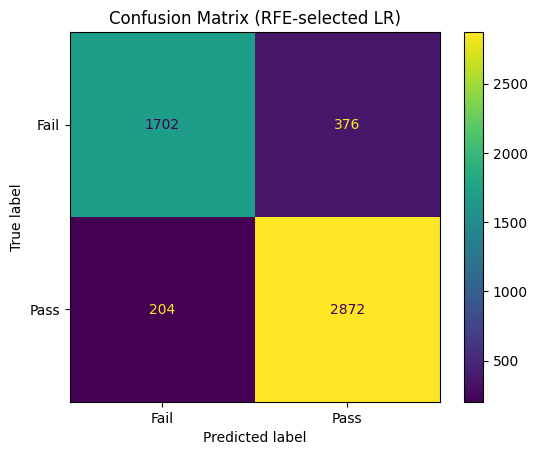

In [24]:
print('Classification report (RFE-selected LR):')
print(classification_report(y_test, y_pred_fs, target_names=['Fail','Pass']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fs, display_labels=['Fail','Pass'])
plt.title('Confusion Matrix (RFE-selected LR)')
plt.show()


### 8.1 Interpretation and Recommendations

Early engagement and consistent activity are strong early-warning signals. Use outreach for low engagement and monitor module-level gaps.


In [25]:
# --- Rubric alignment summary (auto)
print('Rubric alignment summary')
print('- Missing values handled with imputation and explicit cleaning steps')
print('- Noise reduced by removing invalid assessment ids and deduplicating VLE clicks')
print('- Feature engineering includes engagement, registration, and ratio features')
print('- Early warning mode avoids assessment leakage features')

print('\nBaseline metrics:', baseline_metrics)
if 'rfecv_metrics' in globals():
    print('RFECV metrics:', rfecv_metrics)

# Best model from tuned results if available
if 'tuned_results' in globals():
    best = tuned_results.iloc[0]
    print('Best tuned model:', best['Model'])
    print('Best tuned accuracy:', round(best['Accuracy'], 4))


Rubric alignment summary
- Missing values handled with imputation and explicit cleaning steps
- Noise reduced by removing invalid assessment ids and deduplicating VLE clicks
- Feature engineering includes engagement, registration, and ratio features
- Early warning mode avoids assessment leakage features

Baseline metrics: {'Accuracy': 0.8874660457896779, 'Precision': 0.8842364532019704, 'Recall': 0.9336801040312094, 'F1': 0.9082858950031626}
RFECV metrics: {'Accuracy': 0.8874660457896779, 'Precision': 0.8842364532019704, 'Recall': 0.9336801040312094, 'F1': 0.9082858950031626}


## Rubric Alignment Summary

Short comments are printed in the next cell for report writing.


## 9. Bonus Model Comparison

We compare four models only, using two simple and two more complex models:
- Simple: Logistic Regression, Decision Tree
- Complex: Random Forest, HistGradientBoosting


In [26]:
models = {
    'LogReg (balanced)': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    'HistGradientBoosting': HistGradientBoostingClassifier(learning_rate=0.1, max_depth=6, max_iter=300, random_state=42)
}

rows = []
for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1': f1_score(y_test, pred)
    })

bonus_results = pd.DataFrame(rows).sort_values('F1', ascending=False)
bonus_results



,Model,Accuracy,Precision,Recall,F1
3,HistGradientBoosting,0.905122,0.880777,0.972692,0.924455
2,Random Forest,0.890958,0.868190,0.963589,0.913405
0,LogReg (balanced),0.887466,0.884236,0.933680,0.908286
1,Decision Tree,0.871556,0.841153,0.967490,0.899909


## 10. Conclusions and Next Steps

The dataset is large and realistic. Future work can explore time-window features, threshold tuning, and course-specific signals.
